<a href="https://colab.research.google.com/github/BayramGurbuz/diabetic-retinopathy-detection/blob/main/diabetic_retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # lütfen 'kaggle.json' seçin


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c aptos2019-blindness-detection

In [ ]:
import zipfile, os

zip_path = '/content/aptos2019-blindness-detection.zip'
output_dir = '/content/data/'
os.makedirs(output_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(output_dir)

print('ZIP çıkarıldı:', output_dir)
!ls -lah /content/data


In [ ]:
import os, cv2, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
train_csv = "/content/data/train.csv"
image_dir = "/content/data/train_images"
test_dir  = "/content/data/test_images"

df = pd.read_csv(train_csv)
df['id_code'] = df['id_code'].astype(str)
df['file_path'] = df['id_code'].apply(lambda x: f"{image_dir}/{x}.png")
df['exists'] = df['file_path'].apply(os.path.exists)

print("Toplam:", len(df))
print("Var olan görüntü:", df['exists'].sum(), " | Eksik:", (~df['exists']).sum())
df_clean = df[df['exists']].reset_index(drop=True)
df_clean.head()


Toplam: 3662
Var olan görüntü: 3662  | Eksik: 0


id_code  diagnosis                                    file_path  \
0  000c1434d8d7          2  /content/data/train_images/000c1434d8d7.png   
1  001639a390f0          4  /content/data/train_images/001639a390f0.png   
2  0024cdab0c1e          1  /content/data/train_images/0024cdab0c1e.png   
3  002c21358ce6          0  /content/data/train_images/002c21358ce6.png   
4  005b95c28852          0  /content/data/train_images/005b95c28852.png   

   exists  
0    True  
1    True  
2    True  
3    True  
4    True

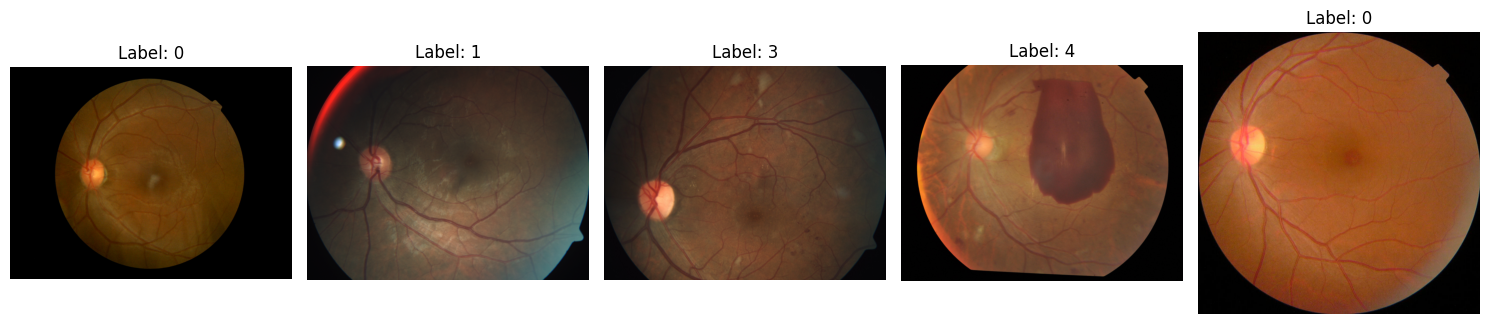

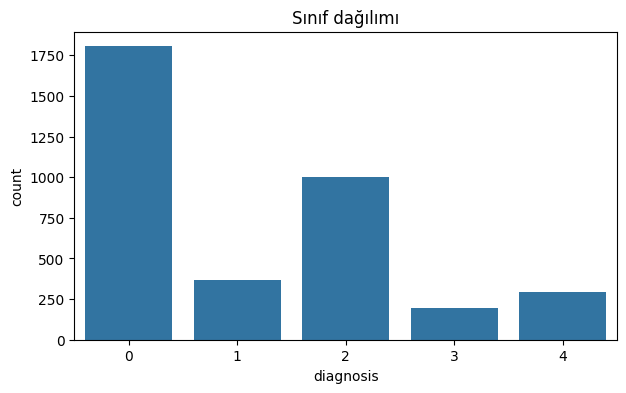

In [ ]:
# Rastgele örnekler
samples = df_clean.sample(5, random_state=42)
plt.figure(figsize=(15,4))
for i,(p,label) in enumerate(zip(samples['file_path'], samples['diagnosis'])):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i+1)
    plt.imshow(img); plt.title(f"Label: {label}"); plt.axis('off')
plt.tight_layout(); plt.show()

# Sınıf dağılımı
plt.figure(figsize=(7,4))
sns.countplot(data=df_clean, x='diagnosis')
plt.title("Sınıf dağılımı"); plt.show()


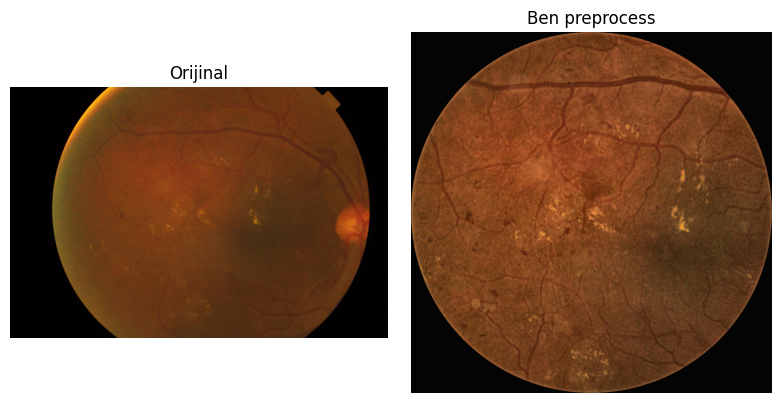

In [ ]:
def crop_foreground(img, tol=7):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0,x0 = coords.min(axis=0); y1,x1 = coords.max(axis=0)+1
        return img[y0:y1, x0:x1]
    return img

def ben_preprocess(img, radius_scale=0.9):
    # kare kırp
    h,w = img.shape[:2]
    s = min(h,w)
    y0=(h-s)//2; x0=(w-s)//2
    img = img[y0:y0+s, x0:x0+s]

    # dairesel maske
    mask = np.zeros((s,s), np.uint8)
    cv2.circle(mask, (s//2,s//2), int(s*radius_scale/2), 255, -1)
    img = cv2.bitwise_and(img, img, mask=mask)

    # unsharp + CLAHE
    blur = cv2.GaussianBlur(img, (0,0), 10)
    img = cv2.addWeighted(img, 1.5, blur, -0.5, 0)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(l)
    img = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB)

    # arka plan kırpma
    img = crop_foreground(img)
    return img

# hızlı demo
demo = cv2.cvtColor(cv2.imread(df_clean.iloc[0]['file_path']), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(demo); plt.title("Orijinal"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ben_preprocess(demo)); plt.title("Ben preprocess"); plt.axis('off')
plt.tight_layout(); plt.show()


In [ ]:
!pip -q install albumentations

In [ ]:
import albumentations as A

IMG_SIZE = 256  # EfficientNetB0 için 224 de olur; 256 biraz daha detay sağlar

train_aug = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.6, border_mode=cv2.BORDER_REFLECT_101),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.6),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    A.GaussianBlur(blur_limit=3, p=0.15),
    A.RandomGamma(p=0.25),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.15),
])

val_aug = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
])

/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/transforms.py:1952: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [ ]:
def load_image_np(path, label, augment=True):
    p = path.decode()
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = ben_preprocess(img)
    img = (train_aug if augment else val_aug)(image=img)['image']
    img = img.astype(np.float32) / 255.0
    return img, np.int32(label)

def tf_parse(path, label, augment):
    image, lab = tf.numpy_function(
        load_image_np, [path, label, augment], [tf.float32, tf.int32]
    )
    # Explicitly set the shapes
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    lab.set_shape([]) # Scalar label
    lab = tf.cast(lab, tf.int32)
    return image, tf.one_hot(lab, 5, dtype=tf.float32)

def make_dataset(df, augment=True, batch_size=32, shuffle=True):
    paths = df['id_code'].apply(lambda x: os.path.join(image_dir, f"{x}.png")).values
    labels = df['diagnosis'].astype(np.int32).values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(4096, reshuffle_each_iteration=True)
    ds = ds.map(lambda x,y: tf_parse(x,y,augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
df_clean['diagnosis'] = df_clean['diagnosis'].astype(np.int32)
classes = np.unique(df_clean['diagnosis'])
class_weights_arr = compute_class_weight(class_weight='balanced', classes=classes, y=df_clean['diagnosis'])
class_weights = {int(c): float(w) for c,w in zip(classes, class_weights_arr)}
print("Class weights:", class_weights)

# Focal loss + alpha (az bulunan sınıfları vurgula)
def categorical_focal_loss(gamma=2.0, alpha=None):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0-1e-7)
        ce = -y_true * tf.math.log(y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        focal = tf.pow(1-pt, gamma) * ce
        if alpha is not None:
            a = tf.constant(alpha, dtype=tf.float32)
            focal = focal * a
        return tf.reduce_sum(focal, axis=-1)
    return loss

# sınıf 0 bol, 1/3/4 az: onlara daha yüksek alpha
ALPHA = [0.5, 1.2, 1.0, 1.3, 1.2]


Class weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [ ]:
train_df, val_df = train_test_split(df_clean[['id_code','diagnosis']], test_size=0.2,
                                    stratify=df_clean['diagnosis'], random_state=42)

train_ds = make_dataset(train_df, augment=True,  batch_size=32, shuffle=True)
val_ds   = make_dataset(val_df,   augment=False, batch_size=32, shuffle=False)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model

def build_model(input_size=IMG_SIZE):
    base = EfficientNetB0(include_top=False, weights='imagenet',
                          input_tensor=Input(shape=(input_size, input_size, 3)))
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.4)(x)
    out = Dense(5, activation='softmax')(x)
    return Model(base.input, out)

model = build_model()

# Aşama 1: backbone freeze
for l in model.layers:
    if 'efficientnet' in l.name:
        l.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=categorical_focal_loss(gamma=2.0, alpha=ALPHA),
              metrics=['accuracy'])


model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 256, 256,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 256, 256,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

os.makedirs("models", exist_ok=True)

callbacks = [
    ModelCheckpoint("models/best_model.keras", monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

# Aşama 1
history1 = model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=callbacks)

# Aşama 2: üst katmanları aç (yaklaşık %40’ını)
total = len(model.layers)
for i,l in enumerate(model.layers):
    if 'efficientnet' in l.name:
        l.trainable = (i > int(total*0.6))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=categorical_focal_loss(gamma=2.0, alpha=ALPHA),
              metrics=['accuracy'])


history2 = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

model.save("models/final_model.keras")
print("Eğitim tamamlandı, modeller kaydedildi.")


Epoch 1/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5246 - loss: 0.6404
Epoch 1: val_loss improved from inf to 0.92561, saving model to models/best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.5258 - loss: 0.6390 - val_accuracy: 0.1010 - val_loss: 0.9256
Epoch 2/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7372 - loss: 0.3759
Epoch 2: val_loss improved from 0.92561 to 0.88938, saving model to models/best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.7372 - loss: 0.3759 - val_accuracy: 0.1010 - val_loss: 0.8894
Epoch 3/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7950 - loss: 0.2903
Epoch 3: val_loss did not improve from 0.88938
92/92 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7948 - loss: 0.2904 - val_accuracy: 0.1023 - val_loss: 1.0187
Epoch 4/6
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7973 - loss: 0.2783
Epoch 4: val_loss improved from 0.88938 to 0.85255, saving model to models/best_model.keras
92/92

In [ ]:
!pip -q install scikit-learn==1.5.1

              precision    recall  f1-score   support

           0      0.907     0.571     0.701       361
           1      0.129     0.432     0.199        74
           2      0.478     0.610     0.536       200
           3      0.500     0.026     0.049        39
           4      0.000     0.000     0.000        59

    accuracy                          0.492       733
   macro avg      0.403     0.328     0.297       733
weighted avg      0.617     0.492     0.514       733

Quadratic Weighted Kappa: 0.4977052067904214


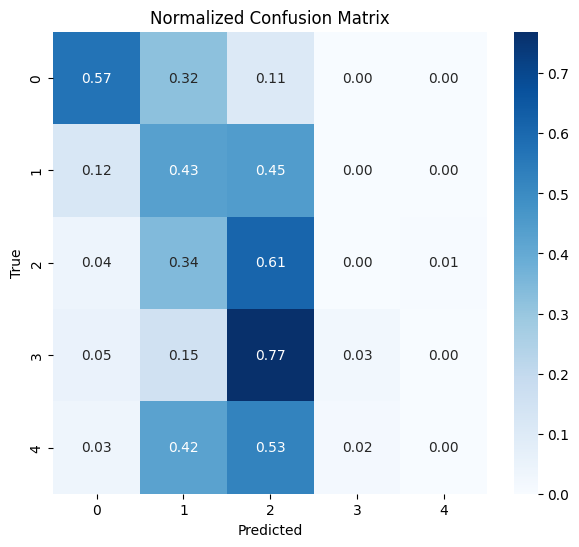

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

def load_for_eval(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = ben_preprocess(img)
    img = val_aug(image=img)['image'].astype(np.float32)/255.0
    return img

val_paths = val_df['id_code'].apply(lambda x: os.path.join(image_dir, f"{x}.png")).values
y_true = val_df['diagnosis'].values

images = np.stack([load_for_eval(p) for p in val_paths], axis=0)

model_eval = tf.keras.models.load_model(
    "models/best_model.keras",
    custom_objects={'loss': categorical_focal_loss(gamma=2.0, alpha=ALPHA)}
)

y_prob = model_eval.predict(images, batch_size=32, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, digits=3))
print("Quadratic Weighted Kappa:", cohen_kappa_score(y_true, y_pred, weights='quadratic'))

cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_7']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


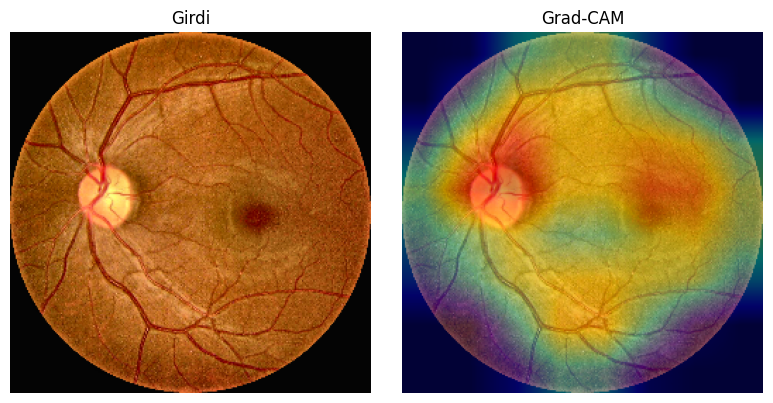

In [68]:
from tensorflow.keras.models import Model

def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D,
                              tf.keras.layers.SeparableConv2D,
                              tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    # EfficientNet fallback
    try:
        return model.get_layer('top_conv').name
    except:
        raise ValueError("Uygun konvolüsyon katmanı bulunamadı.")

def make_gradcam_heatmap(img_array, model, pred_index=None, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer(model)
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_out[0]), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

def preprocess_for_cam(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = ben_preprocess(img)
    img = val_aug(image=img)['image'].astype(np.float32)/255.0
    return img

def visualize_gradcam(path, model):
    img = preprocess_for_cam(path)
    x = np.expand_dims(img, 0)
    heatmap = make_gradcam_heatmap(x, model)
    hm = cv2.resize((heatmap*255).astype(np.uint8), (IMG_SIZE, IMG_SIZE))
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    base = (img*255).astype(np.uint8)
    overlay = cv2.addWeighted(base, 0.6, cv2.cvtColor(hm, cv2.COLOR_BGR2RGB), 0.4, 0)
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(base); plt.title("Girdi"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis('off')
    plt.tight_layout(); plt.show()

# Örnek kullanım
sample_path = os.path.join(image_dir, f"{val_df.iloc[0]['id_code']}.png")
visualize_gradcam(sample_path, model_eval)


Kaydedildi -> test_predictions.csv


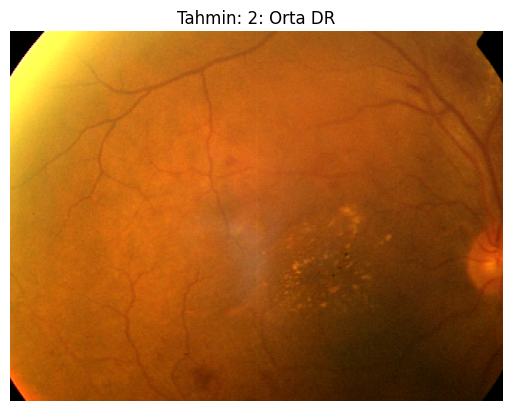

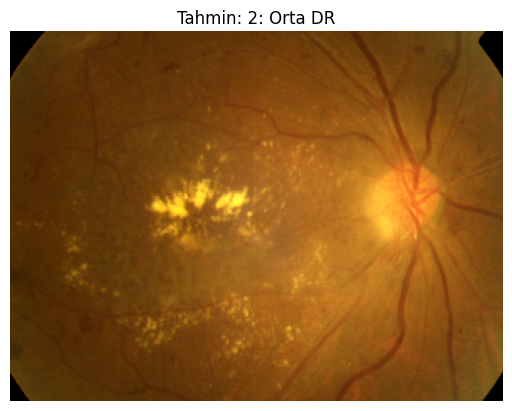

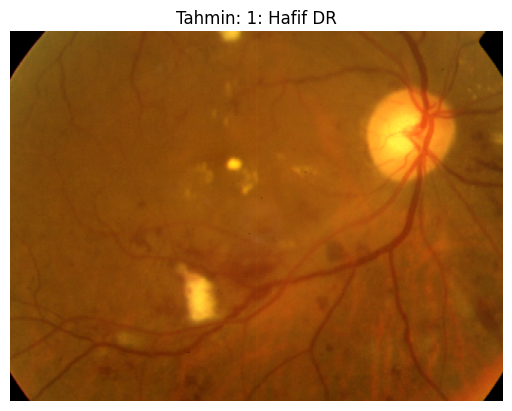

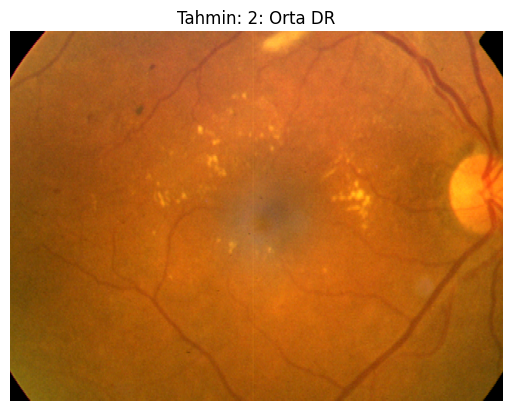

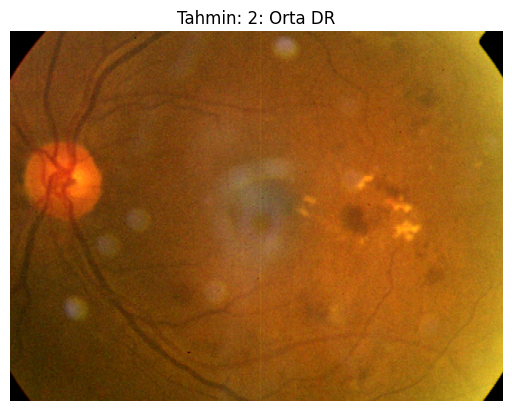

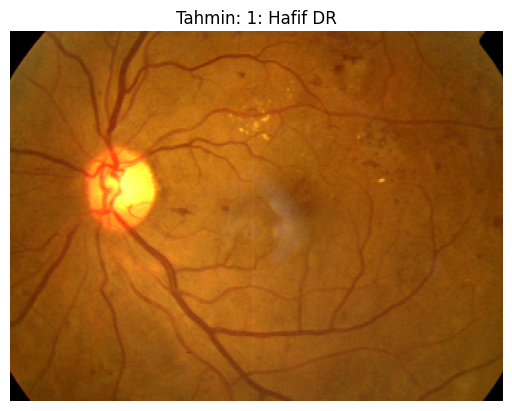

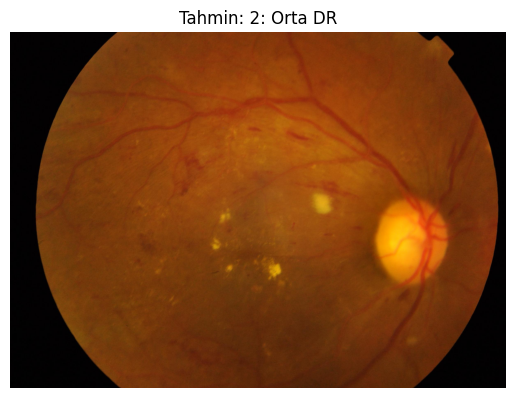

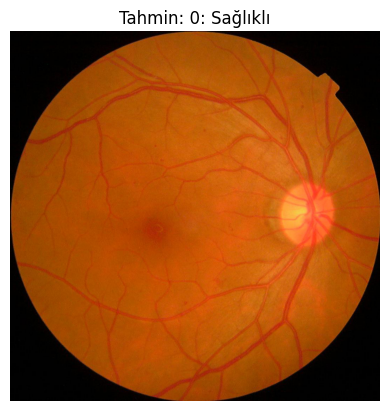

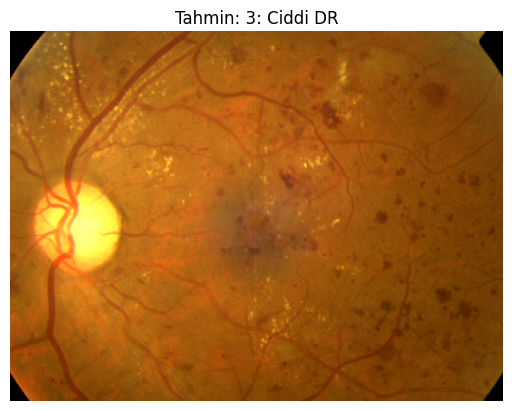

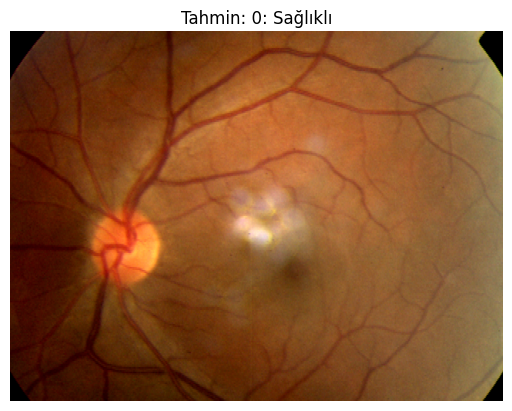

In [69]:
test_csv = "/content/data/test.csv"
test_df = pd.read_csv(test_csv)
test_df['image_path'] = test_df['id_code'].apply(lambda x: f"{test_dir}/{x}.png")

preds = []
for p in test_df['image_path']:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    img = ben_preprocess(img)
    img = val_aug(image=img)['image'].astype(np.float32)/255.0
    x = np.expand_dims(img, 0)
    pr = model_eval.predict(x, verbose=0)[0]
    preds.append(int(np.argmax(pr)))

test_df['predicted_label'] = preds
out_csv = "test_predictions.csv"
test_df[['id_code','predicted_label']].to_csv(out_csv, index=False)
print("Kaydedildi ->", out_csv)

# İlk 10 görseli gözlemleyelim
class_names = ['0: Sağlıklı', '1: Hafif DR', '2: Orta DR', '3: Ciddi DR', '4: Proliferatif DR']
for i in range(min(10, len(test_df))):
    img = cv2.cvtColor(cv2.imread(test_df['image_path'].iloc[i]), cv2.COLOR_BGR2RGB)
    plt.imshow(img); plt.title(f"Tahmin: {class_names[test_df['predicted_label'].iloc[i]]}")
    plt.axis('off'); plt.show()


In [70]:
app_code = r"""
import streamlit as st
import numpy as np
import cv2, os
import tensorflow as tf

st.set_page_config(page_title='DR Tespiti (EfficientNetB0)', layout='wide')
IMG_SIZE = 256
CLASS_NAMES = ['0: Sağlıklı', '1: Hafif DR', '2: Orta DR', '3: Ciddi DR', '4: Proliferatif DR']
ALPHA = [0.5, 1.2, 1.0, 1.3, 1.2]

def crop_foreground(img, tol=7):
    import cv2, numpy as np
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0,x0 = coords.min(axis=0); y1,x1 = coords.max(axis=0)+1
        return img[y0:y1, x0:x1]
    return img

def ben_preprocess(img, radius_scale=0.9):
    import cv2, numpy as np
    h,w = img.shape[:2]
    s = min(h,w)
    y0=(h-s)//2; x0=(w-s)//2
    img = img[y0:y0+s, x0:x0+s]
    mask = np.zeros((s,s), np.uint8)
    cv2.circle(mask, (s//2,s//2), int(s*radius_scale/2), 255, -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    blur = cv2.GaussianBlur(img, (0,0), 10)
    img = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(2.0, (8,8)).apply(l)
    img = cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB)
    img = crop_foreground(img)
    return img

def pad_resize(img, size=IMG_SIZE):
    import cv2, numpy as np
    h, w = img.shape[:2]
    scale = size / max(h, w)
    nh, nw = int(h*scale), int(w*scale)
    img = cv2.resize(img, (nw, nh))
    canvas = np.zeros((size, size, 3), dtype=img.dtype)
    y0 = (size-nh)//2; x0 = (size-nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = img
    return canvas

def categorical_focal_loss(gamma=2.0, alpha=None):
    import tensorflow as tf
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0-1e-7)
        ce = -y_true * tf.math.log(y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        focal = tf.pow(1-pt, gamma) * ce
        if alpha is not None:
            a = tf.constant(alpha, dtype=tf.float32)
            focal = focal * a
        return tf.reduce_sum(focal, axis=-1)
    return loss

@st.cache_resource
def load_dr_model():
    return tf.keras.models.load_model('models/best_model.keras',
        custom_objects={'loss': categorical_focal_loss(gamma=2.0, alpha=ALPHA)})

def find_last_conv_layer(model):
    import tensorflow as tf
    for layer in reversed(model.layers):
        if isinstance(layer, (tf.keras.layers.Conv2D,
                              tf.keras.layers.SeparableConv2D,
                              tf.keras.layers.DepthwiseConv2D)):
            return layer.name
    try:
        return model.get_layer('top_conv').name
    except:
        return None

def make_gradcam_heatmap(img_array, model, pred_index=None, last_conv_layer_name=None):
    import tensorflow as tf, cv2, numpy as np
    if last_conv_layer_name is None:
        last_conv_layer_name = find_last_conv_layer(model)
    grad_model = tf.keras.models.Model([model.inputs],
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_out[0]), axis=-1)
    cam = tf.maximum(cam, 0)
    cam = cam / (tf.reduce_max(cam) + 1e-8)
    return cam.numpy()

st.title('👁️ Diyabetik Retinopati Tespiti — EfficientNetB0')
st.caption('APTOS 2019 • Ben’s preprocessing • Focal Loss • Grad-CAM')

uploaded = st.file_uploader('Fundus görüntüsü yükle (.jpg/.png)', type=['jpg','jpeg','png'])
if uploaded is not None:
    file_bytes = np.frombuffer(uploaded.read(), np.uint8)
    bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    rgb = ben_preprocess(rgb)
    rgb = pad_resize(rgb, IMG_SIZE)
    x = rgb.astype(np.float32)/255.0
    x = np.expand_dims(x, 0)

    model = load_dr_model()
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))

    col1, col2 = st.columns([1,1])
    with col1:
        st.subheader('Ön-işlenmiş Görüntü')
        st.image(rgb, use_container_width=True)

    with col2:
        st.subheader('Olasılıklar')
        st.bar_chart({CLASS_NAMES[i]: float(probs[i]) for i in range(5)})
        st.metric('Tahmin', CLASS_NAMES[pred_idx])

    heat = make_gradcam_heatmap(x, model)
    h = (heat*255).astype(np.uint8)
    h = cv2.resize(h, (IMG_SIZE, IMG_SIZE))
    h = cv2.applyColorMap(h, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(rgb.astype(np.uint8), 0.6, cv2.cvtColor(h, cv2.COLOR_BGR2RGB), 0.4, 0)

    st.subheader('Grad-CAM')
    st.image(overlay, use_container_width=True)
"""
with open("app.py", "w", encoding="utf-8") as f:
    f.write(app_code)

print("app.py yazıldı.")
!sed -n '1,60p' app.py


app.py yazıldı.

import streamlit as st
import numpy as np
import cv2, os
import tensorflow as tf

st.set_page_config(page_title='DR Tespiti (EfficientNetB0)', layout='wide')
IMG_SIZE = 256
CLASS_NAMES = ['0: Sağlıklı', '1: Hafif DR', '2: Orta DR', '3: Ciddi DR', '4: Proliferatif DR']
ALPHA = [0.5, 1.2, 1.0, 1.3, 1.2]

def crop_foreground(img, tol=7):
    import cv2, numpy as np
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray > tol
    if mask.any():
        coords = np.argwhere(mask)
        y0,x0 = coords.min(axis=0); y1,x1 = coords.max(axis=0)+1
        return img[y0:y1, x0:x1]
    return img

def ben_preprocess(img, radius_scale=0.9):
    import cv2, numpy as np
    h,w = img.shape[:2]
    s = min(h,w)
    y0=(h-s)//2; x0=(w-s)//2
    img = img[y0:y0+s, x0:x0+s]
    mask = np.zeros((s,s), np.uint8)
    cv2.circle(mask, (s//2,s//2), int(s*radius_scale/2), 255, -1)
    img = cv2.bitwise_and(img, img, mask=mask)
    blur = cv2.GaussianBlur(img, (0,0), 10)
    img = cv

In [71]:
!pip -q install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [72]:
# NGROK TOKEN'INI BURAYA YAZIN (veya önce hücre dışından 'ngrok config add-authtoken ...'):
NGROK_TOKEN = "318VTvHWSf8t4x8ly5AOepO0pXV_AjtqYxHbvzCkZCi9hmav"

from pyngrok import ngrok, conf
import time, os, signal, subprocess

if NGROK_TOKEN and NGROK_TOKEN != "PASTE_YOUR_TOKEN_HERE":
    conf.get_default().auth_token = NGROK_TOKEN

# Eski tünelleri kapat
try:
    for t in ngrok.get_tunnels():
        ngrok.disconnect(t.public_url)
except Exception:
    pass
ngrok.kill()

# Streamlit'i başlat
proc = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])
time.sleep(3)

public_url = ngrok.connect(addr="8501", proto="http")
print("Streamlit URL:", public_url)


Streamlit URL: NgrokTunnel: "https://0ecc0c14335d.ngrok-free.app" -> "http://localhost:8501"
